In [1]:
from automl_surrogate.data.heterogeneous.dataset import HeteroPipelineDataset
from automl_surrogate.models.heterogeneous.listwise.pipelines_ranking import HeteroPipelineRankingSurrogateModel
import yaml

/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
with open ("/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/id2pipeline_path.pickle", "rb") as f:
    id2pipe = pickle.load(f)
with open ("/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/id2dataset_id.pickle", "rb") as f:
    id2dataset = pickle.load(f)

ds = HeteroPipelineDataset(
    "/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/train_task_pipe_comb.csv",
    id2pipe,
    id2dataset,
    pipelines_per_step=30,
    use_dataset_with_id=27,
)

/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_squared link alias is deprecated. Use InverseSquared instead. The

In [3]:
samples = [ds[i] for i in range(128)]
batch = ds.collate_fn(samples)
x, y = batch

In [4]:
with open("/home/cherniak/itmo_job/surrogate/configs/mhsa_ranking_surrogate.yml") as f:
    config = yaml.safe_load(f)
model_config = {k: v for k, v in config["model"].items() if k != "class"}

In [5]:
import torch
model = HeteroPipelineRankingSurrogateModel(**model_config)
state_dict = torch.load(
    "/home/cherniak/itmo_job/surrogate/experiment_logs/no_meta_features_and_fedot_pipelines_(type_and_hparams)/train_node_embedder_from_scratch/overfit_27th_dataset/simple_graph_encoder/rank_over_10/mhsa/version_0/checkpoints/last.ckpt",
    map_location="cpu",
)["state_dict"]
model.load_state_dict(state_dict)
model = model.eval()

In [7]:
with torch.no_grad():
    node_embeddings = [model.node_embedder(p) for p in x]

In [25]:
from collections import defaultdict
embs = defaultdict(list)
for i in range(len(node_embeddings)):
    for k, v in node_embeddings[i].items():
        embs[k].append(v[:, :8])
for k, v in embs.items():
    embs[k] = torch.vstack(v)

In [59]:
import numpy as np
import matplotlib.colors as mcolors

selected_colors = np.random.choice(list(mcolors.CSS4_COLORS.values()), len(embs.keys()), replace=False)

colors_all = []
embs_all = []
indexes = []
for i, (k,v) in enumerate(embs.items()):
    # colors_all.extend([i] * len(v))
    colors_all.extend([selected_colors[i]] * len(v))
    embs_all.append(v)
    if len(indexes) == 0:
        indexes.append([0, len(v)])
    else:
        indexes.append([indexes[-1][1], indexes[-1][1] + len(v)])
embs_all = torch.vstack(embs_all)
embs_all.shape

torch.Size([24116, 8])

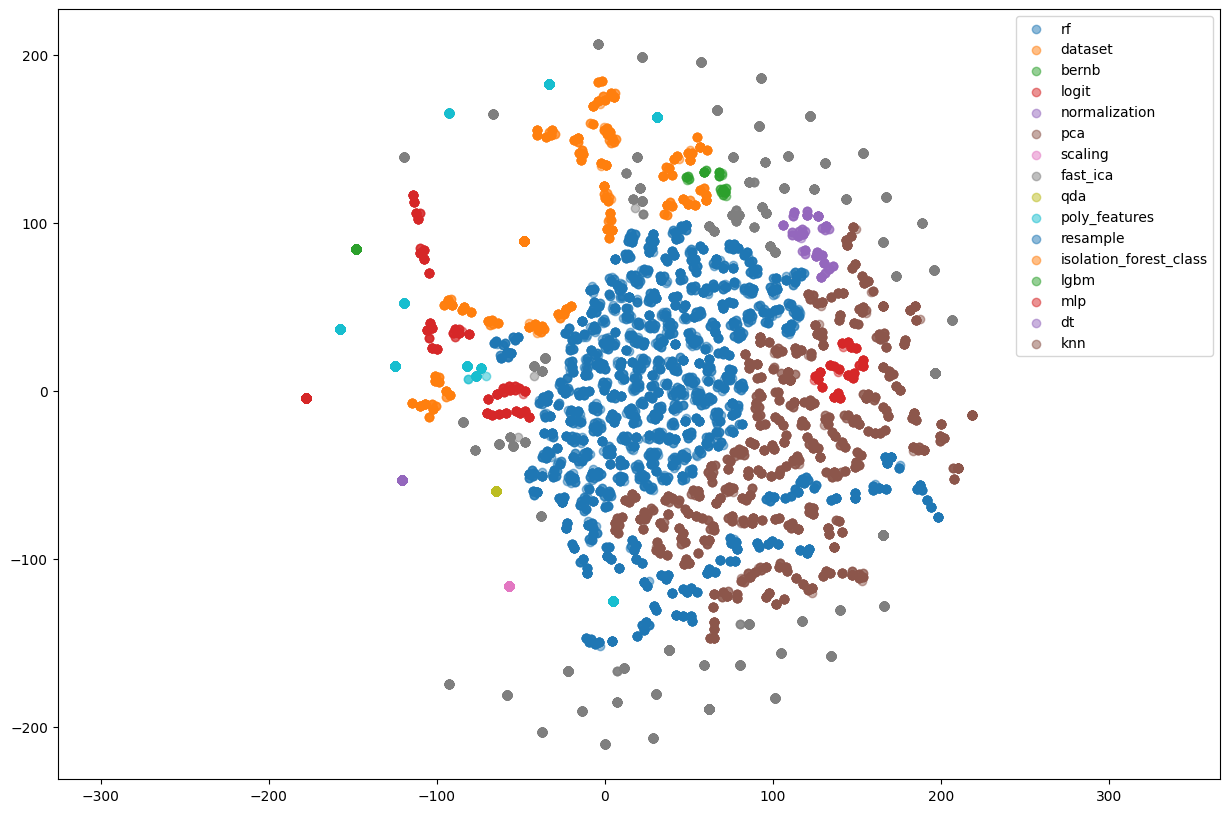

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0, init='pca')
transformed = tsne.fit_transform(embs_all.numpy())
fig = plt.figure(figsize=(15,10))
plt.axis("equal")
for i, (start, stop) in enumerate(indexes):
    plt.scatter(*transformed[start: stop].T, alpha=0.5)
plt.legend(list(embs.keys()))